In [67]:
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [68]:
df = pd.read_csv('fake_job_postings.csv')

In [69]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [70]:
df.shape

(17880, 18)

In [71]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [72]:
columns = ['job_id','telecommuting','has_company_logo','has_questions','salary_range','employment_type']
for cols in columns:
    del df[cols]

In [73]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,Internship,NaN,NaN,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,NaN,NaN,NaN,NaN,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [74]:
df.fillna('',inplace=True)

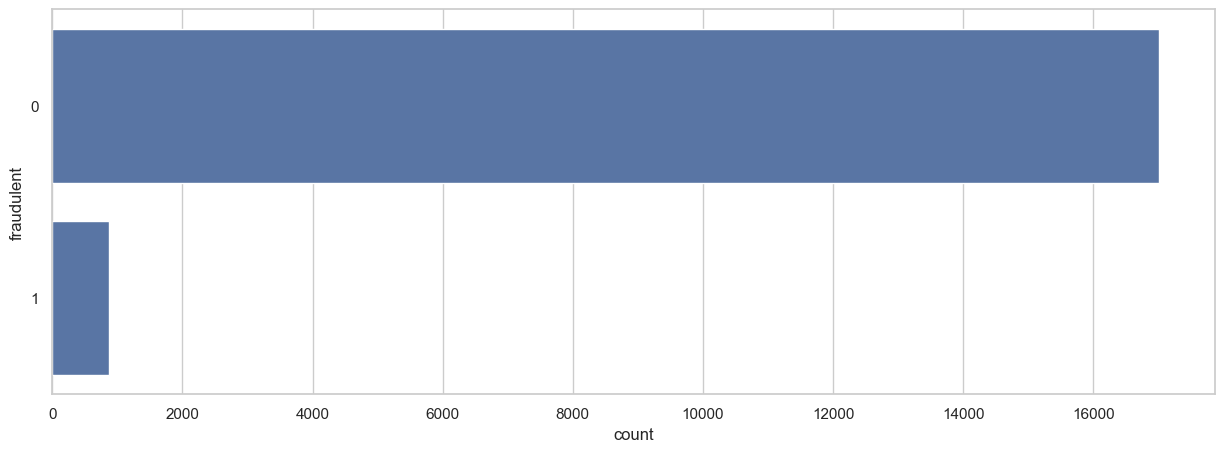

In [75]:
plt.figure(figsize=(15,5))
sns.countplot(y='fraudulent',data=df)
plt.show()

In [76]:
df.groupby('fraudulent')['fraudulent'].count()

fraudulent
0    17014
1      866
Name: fraudulent, dtype: int64

In [77]:
exp = dict(df.required_experience.value_counts())
del exp['']

In [78]:
exp

{'Mid-Senior level': np.int64(3809),
 'Entry level': np.int64(2697),
 'Associate': np.int64(2297),
 'Not Applicable': np.int64(1116),
 'Director': np.int64(389),
 'Internship': np.int64(381),
 'Executive': np.int64(141)}

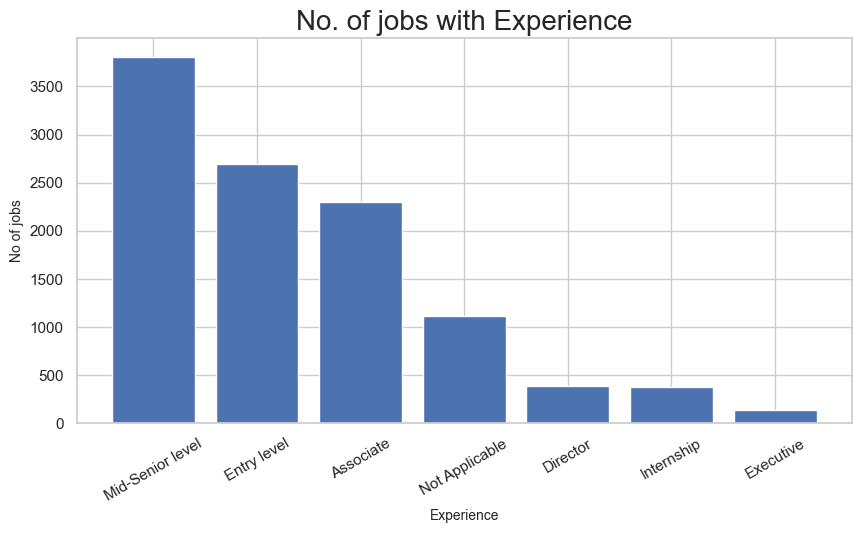

In [79]:
plt.figure(figsize=(10,5))
sns.set_theme(style='whitegrid')
plt.bar(exp.keys(),exp.values())
plt.title('No. of jobs with Experience',size=20)
plt.xlabel('Experience',size=10)
plt.ylabel('No of jobs',size=10)
plt.xticks(rotation=30)
plt.show()

In [80]:
def split(location):
    l = location.split(',')
    return l[0]
df['country'] = df.location.apply(split)

In [81]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


In [82]:
countr = dict(df.country.value_counts()[:14])
del countr['']
countr

{'US': np.int64(10656),
 'GB': np.int64(2384),
 'GR': np.int64(940),
 'CA': np.int64(457),
 'DE': np.int64(383),
 'NZ': np.int64(333),
 'IN': np.int64(276),
 'AU': np.int64(214),
 'PH': np.int64(132),
 'NL': np.int64(127),
 'BE': np.int64(117),
 'IE': np.int64(114),
 'SG': np.int64(80)}

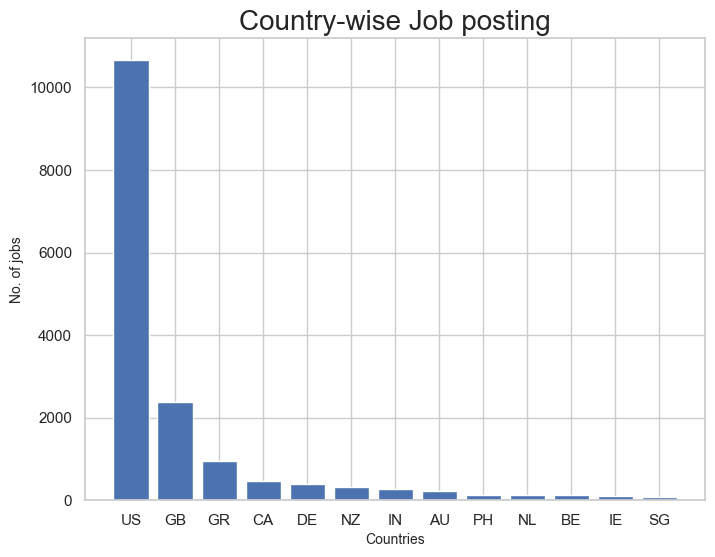

In [83]:
plt.figure(figsize=(8,6))
plt.title('Country-wise Job posting',size=20)
plt.bar(countr.keys(),countr.values())
plt.ylabel('No. of jobs',size=10)
plt.xlabel('Countries',size=10)
plt.show()

In [84]:
edu = dict(df.required_education.value_counts()[:7])
del edu['']
edu

{"Bachelor's Degree": np.int64(5145),
 'High School or equivalent': np.int64(2080),
 'Unspecified': np.int64(1397),
 "Master's Degree": np.int64(416),
 'Associate Degree': np.int64(274),
 'Certification': np.int64(170)}

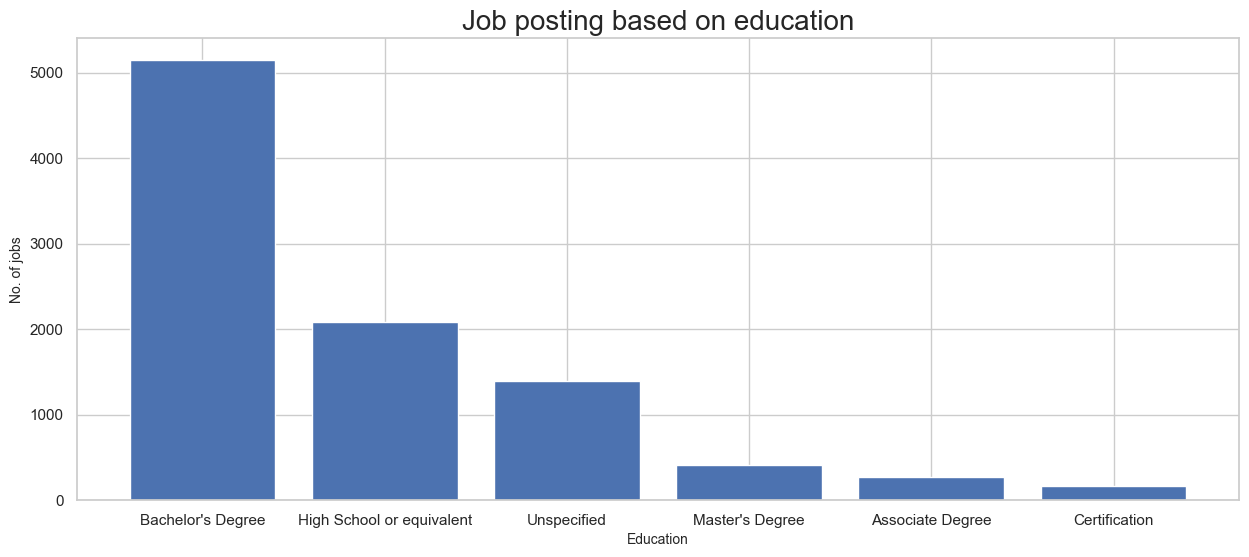

In [85]:
plt.figure(figsize=(15,6))
plt.title('Job posting based on education',size=20)
plt.bar(edu.keys(),edu.values())
plt.ylabel('No. of jobs',size=10)
plt.xlabel('Education',size=10)
plt.show()

In [86]:
print(df[df.fraudulent==0].title.value_counts()[:10])

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: count, dtype: int64


In [87]:
print(df[df.fraudulent==1].title.value_counts()[:10])

title
Data Entry Admin/Clerical Positions - Work From Home                    21
Cruise Staff Wanted *URGENT*                                            21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Account Sales Managers $80-$130,000/yr                                  10
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Network Marketing                                                       10
Payroll Clerk                                                           10
Name: count, dtype: int64


In [88]:
print(df.columns.tolist())

['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent', 'country']


In [89]:
df['text'] = (
    df['title'].fillna('') + ' ' +
    df['description'].fillna('') + ' ' +
    df['requirements'].fillna('') + ' ' +
    df['benefits'].fillna('')
)


In [90]:
df.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country,text
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US,"Marketing Intern Food52, a fast-growing, James..."
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ,Customer Service - Cloud Video Production Orga...
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US,Commissioning Machinery Assistant (CMA) Our cl...
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,Account Executive - Washington DC THE COMPANY:...
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,Bill Review Manager JOB TITLE: Itemization Rev...


In [91]:
del df['location']
del df['department']
del df['company_profile']
del df['description']
del df['required_education']
del df['industry']
del df['function']
del df['country']
del df['title']
del df['requirements']
del df['benefits']
del df['required_experience']


In [92]:
df.head()

,fraudulent,text
0,0,"Marketing Intern Food52, a fast-growing, James..."
1,0,Customer Service - Cloud Video Production Orga...
2,0,Commissioning Machinery Assistant (CMA) Our cl...
3,0,Account Executive - Washington DC THE COMPANY:...
4,0,Bill Review Manager JOB TITLE: Itemization Rev...


In [93]:
fraudjobs_text = df[df.fraudulent==1].text
real_jobs_text = df[df.fraudulent==0].text

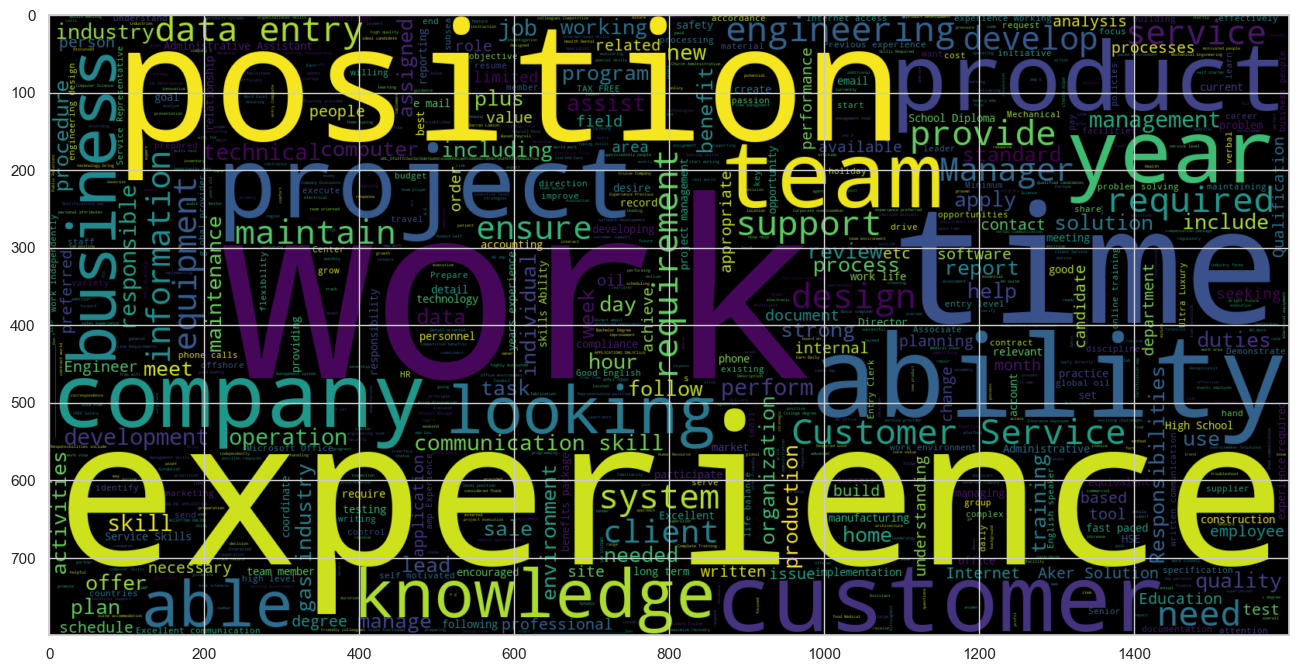

In [94]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc = WordCloud(min_font_size = 3, max_words = 3000, width = 1600, height = 800, stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')                                                                                                               

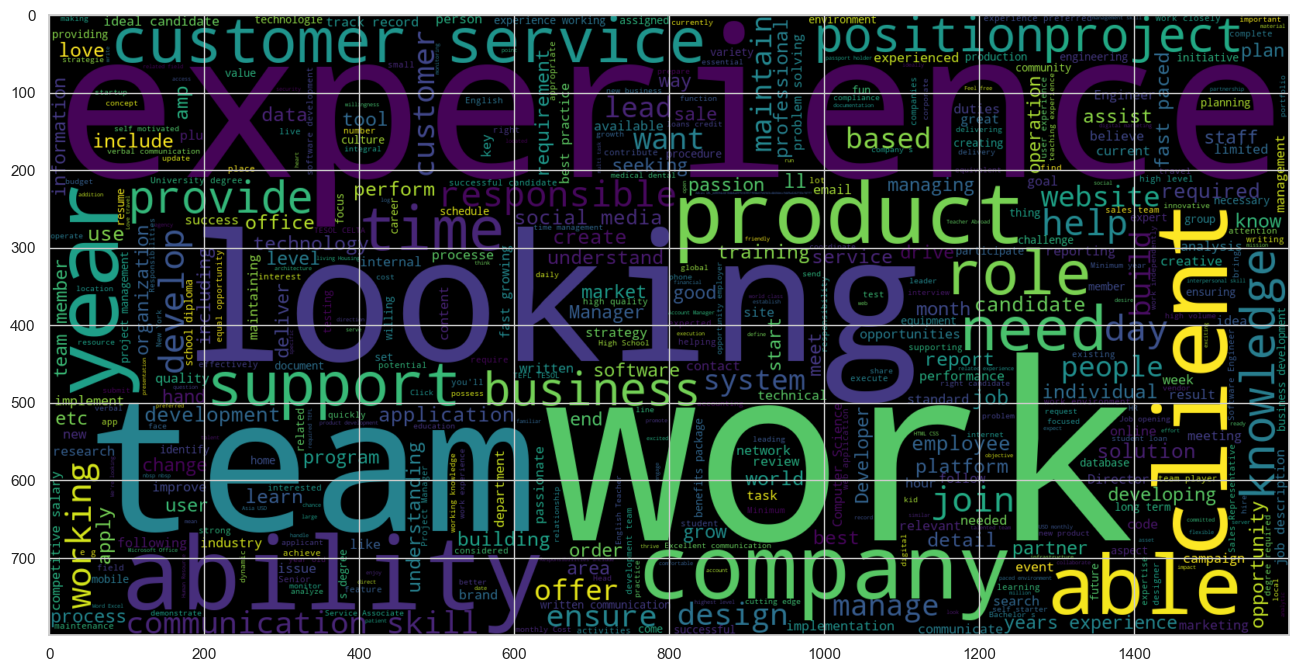

In [95]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16,14))
wc = WordCloud(min_font_size = 3, max_words = 3000, width = 1600, height = 800, stopwords = STOPWORDS).generate(str(" ".join(real_jobs_text)))
plt.imshow(wc,interpolation = 'bilinear')                                                                                                               

In [96]:
!pip install spacy && python -m spacy download en

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.5 MB/s eta 0:00:09
     -- ------------------------------------- 0.8/12.8 MB 1.2 MB/s eta 0:00:10
     ---- ----------------------------------- 1.3/12.8 MB 1.4 MB/s eta 0:00:09
     ---- ----------------------------------- 1.6/12.8 MB 1.4 MB/s eta 0:00:08
     ------ --------------------------------- 2.1/12.8 MB 1.5 MB/s eta 0:00:07
     ------- -------------------------------- 2.4/12.8 MB 1.5 MB/s eta 0:00:07
     --------- ------------------------------ 2.9/12.8 MB 1.7 MB/s eta 0:00:06
     ---------- ----------------------------- 3.4/12.8 MB 1.8 MB/s eta 0:00:06
     ------------- -------------------------- 4.2/12.8 MB 2.0 MB/s eta 0:00:05
 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [97]:
punctuation = string.punctuation

nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

parser = English()

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)

    mytokens = [word.lemma_lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    mytockens = [word for word in mytockens if word not in stop_words and word not in punctuations]

    return mytockens

class predictions(TransformerMixin):
    def transform(self,X,**transform_params):
        return [clean_text(text) for text in X]

    def fit(self,X,y=None,**fit_params):
        return self

    def get_params(self,drop=True):
        return {}

def clean_text(text):
    return text.strip().lower()

In [98]:
df['text'] = df['text'].apply(clean_text)

In [99]:
cv = TfidfVectorizer(max_features = 100)
x = cv.fit_transform(df['text'])
df1 = pd.DataFrame(x.toarray(), columns=cv.get_feature_names_out())
df.drop(['text'],axis=1,inplace=True)
main_df = pd.concat([df1,df],axis=1)

In [100]:
main_df.head()

,ability,able,about,all,amp,an,and,are,as,at,...,who,will,with,within,work,working,years,you,your,fraudulent
0,0.000000,0.000000,0.000000,0.000000,0.065320,0.000000,0.713668,0.000000,0.132812,0.000000,...,0.000000,0.000000,0.269440,0.000000,0.084082,0.113547,0.000000,0.000000,0.000000,0
1,0.024164,0.028825,0.113562,0.020868,0.051591,0.035263,0.448368,0.067537,0.069931,0.064254,...,0.000000,0.087371,0.159605,0.000000,0.049807,0.112101,0.000000,0.239382,0.156167,0
2,0.000000,0.000000,0.000000,0.241068,0.000000,0.101839,0.443962,0.048762,0.000000,0.000000,...,0.000000,0.050466,0.230470,0.000000,0.095895,0.000000,0.000000,0.000000,0.000000,0
3,0.026104,0.000000,0.000000,0.022543,0.000000,0.114278,0.678089,0.000000,0.037771,0.023137,...,0.028612,0.056630,0.086206,0.064709,0.053804,0.000000,0.023508,0.059675,0.072300,0
4,0.000000,0.077847,0.000000,0.056359,0.069666,0.047617,0.622754,0.045600,0.188862,0.000000,...,0.000000,0.000000,0.251443,0.000000,0.044838,0.060550,0.058773,0.000000,0.000000,0


In [101]:
Y = main_df.iloc[:,-1]
X = main_df.iloc[:,:-1]

X_train,X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_train.shape)

(12516, 100)
(12516,)
(5364, 100)
(12516,)


In [102]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=3,oob_score=True,n_estimators=100,criterion="entropy")
model = rfc.fit(X_train,y_train)

In [103]:
print(X_test)

        ability      able     about       all       amp        an       and  \
7091   0.071449  0.000000  0.000000  0.061703  0.076272  0.104265  0.265146   
2920   0.063087  0.000000  0.000000  0.054481  0.000000  0.046031  0.568567   
16002  0.000000  0.176481  0.086911  0.000000  0.000000  0.000000  0.352949   
11732  0.000000  0.000000  0.000000  0.057645  0.000000  0.146113  0.460035   
10572  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.285098   
...         ...       ...       ...       ...       ...       ...       ...   
9590   0.000000  0.000000  0.000000  0.146009  0.360968  0.061681  0.313712   
17235  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.486632   
1041   0.060404  0.000000  0.000000  0.000000  0.000000  0.022037  0.544384   
7406   0.147844  0.000000  0.000000  0.000000  0.000000  0.035958  0.444142   
4440   0.069147  0.000000  0.040620  0.000000  0.000000  0.126132  0.476549   

            are        as        at  ...      well 

In [104]:
pred = rfc.predict(X_test)
score = accuracy_score(y_test,pred)
score

0.9683072334079046

In [105]:
print("Classification Report\n")
print(classification_report(y_test,pred))
print("Confusion Matrix\n")
print(confusion_matrix(y_test,pred))

Classification Report

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5087
           1       1.00      0.39      0.56       277

    accuracy                           0.97      5364
   macro avg       0.98      0.69      0.77      5364
weighted avg       0.97      0.97      0.96      5364

Confusion Matrix

[[5087    0]
 [ 170  107]]
